In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import skimage.io
from skimage.transform import resize
from tqdm import trange
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "sklearn\..*" )

%matplotlib inline

### **1) Loading data**

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                  images_name = "lfw-deepfunneled",
                  dx=80,dy=80,
                  dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt", sep='\t', skiprows=1) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])

    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path", "person", "imagenum"], axis=1)
    
    return all_photos, all_attrs

####**1.1) Exploring loaded data**

###**2) Variational Autoencoder (VAE)**

In [ ]:
# laoding MNIST

from torchvision.datasets import MNIST
from torchvision import transforms

data_train = MNIST(root="/data", train=True, download=True, transform=transforms.ToTensor())
data_test = MNIST(root="/data", train=False, download=True, transform=transforms.ToTensor())

train_loader = data_utils.DataLoader(data_train, batch_size=32)
val_loader = data_utils.DataLoader(data_test, batch_size=32)

print(data_train)
print(data_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: /data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [ ]:
for b in val_loader:                        # What is inside the batch from Dataloader
    print(torch.unique(b[0][0]))
    print(b[1])
    break

tensor([0.0000, 0.0039, 0.0118, 0.0196, 0.0353, 0.0549, 0.0667, 0.0706, 0.0745,
        0.0824, 0.0863, 0.1216, 0.1373, 0.1412, 0.1490, 0.1569, 0.1725, 0.2039,
        0.2235, 0.2275, 0.2314, 0.2353, 0.2392, 0.2431, 0.2588, 0.2627, 0.2824,
        0.2941, 0.3020, 0.3255, 0.3294, 0.4157, 0.4471, 0.4510, 0.4745, 0.4941,
        0.5059, 0.5216, 0.5490, 0.5922, 0.6235, 0.6392, 0.6510, 0.6667, 0.7137,
        0.7255, 0.7333, 0.7765, 0.7961, 0.8039, 0.8118, 0.8196, 0.8588, 0.8667,
        0.8706, 0.8784, 0.8824, 0.8902, 0.8980, 0.9137, 0.9255, 0.9333, 0.9412,
        0.9451, 0.9490, 0.9725, 0.9765, 0.9804, 0.9843, 0.9922, 0.9961, 1.0000])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1])


In [ ]:
# FC VAE architecure  for working with MNIST


latent_dim = 8


class VAE_MNIST(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()

        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=latent_dim*2)                                                       
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=28*28),
            nn.Sigmoid()
        )

    def reparametrize(self, d_mean, d_log_var):
        std = torch.exp(0.5 * d_log_var)  
        eps = torch.randn_like(std)        # random piece
        sample = d_mean + (eps * std) 

        return sample
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.encoder(x.to(device).float()).view(-1, 2 , latent_dim)
        
        d_mean = x[:, 0, :]
        d_log_var = x[:, 1, :]

        z = self.reparametrize(d_mean, d_log_var)
        reconstruction = self.decoder(z)

        return reconstruction, d_mean, d_log_var
    
    def get_sample(self, z):
        sample = self.decoder(z)

        return sample
    
    def get_latent_vector(self, x):
        x = self.flatten(x)    
        x = self.encoder(x.to(device).float()).view(-1, 2 , latent_dim)
        d_mean = x[:, 0, :]
        d_log_var = x[:, 1, :]

        z = self.reparametrize(d_mean, d_log_var)
        
        return z

In [ ]:
def KL_divergence(d_mean, d_log_var):
    loss = -0.5 * torch.sum(1 + d_log_var - d_mean.pow(2) - d_log_var.exp())

    return loss


def log_likelihood(x, reconstruction):                      # BCE was not working for some reason
    loss = nn.MSELoss(reduction="sum")                      # default reduction will be "mean"

    return loss(x, reconstruction)


def VAE_loss(x, reconstruction, d_mean, d_log_var):
    loss = KL_divergence(d_mean, d_log_var) + log_likelihood(x, reconstruction)

    return loss

In [ ]:
# Training preparation

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
criterion = VAE_loss
model = VAE_MNIST().to(device)                                    # maybe FCAE(16): make dimension as an __init__() parameter
optimizer = optim.Adam(model.parameters(), lr=3e-4)               # Karpathy constant

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 train loss: 1831.488945377604
Epoch 2 train loss: 1292.6056493164062
Epoch 3 train loss: 1205.166136263021
Epoch 4 train loss: 1164.5887168945312
Epoch 5 train loss: 1137.749840657552
Epoch 6 train loss: 1118.6083885416667
Epoch 7 train loss: 1104.212301139323
Epoch 8 train loss: 1092.9040799153645
Epoch 9 train loss: 1083.1658020182292
Epoch 10 train loss: 1075.4339244791668
Epoch 11 train loss: 1069.446842610677
Epoch 12 train loss: 1064.455755826823
Epoch 13 train loss: 1059.8371919270833
Epoch 14 train loss: 1056.080565983073
Epoch 15 train loss: 1051.982434733073
Epoch 16 train loss: 1049.3710584309895
Epoch 17 train loss: 1046.0806248372396
Epoch 18 train loss: 1043.2502833007813
Epoch 19 train loss: 1041.600510188802
Epoch 20 train loss: 1039.0147046223958


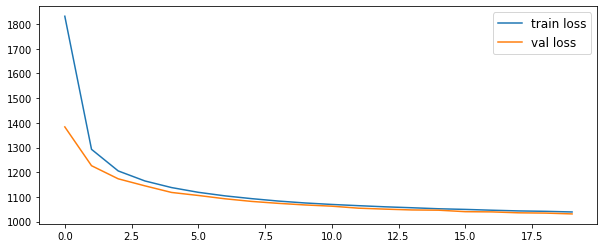

In [ ]:
n_epochs = 20
train_losses = list()
val_losses = list()

plt.figure(figsize=(10, 4))


for epoch in tqdm(range(n_epochs)):             # trange will add a progress bar

    train_losses_in_epoch = list()
    model.train()
    for i_b, batch in enumerate(train_loader):
        batch = batch[0].to(device)

        # "Отче наш" / "Our Lord"
        optimizer.zero_grad()
        reconstruction, p_mean, p_log_var = model(batch)

        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch.float(), reconstruction, p_mean, p_log_var)
        loss.backward()
        optimizer.step()

        train_losses_in_epoch.append(loss.item())
    
    print(f"Epoch {epoch + 1} train loss: {np.mean(train_losses_in_epoch)}")
    train_losses.append(np.mean(train_losses_in_epoch))

    val_losses_in_epoch = list()
    model.eval()
    for i_b, batch in enumerate(val_loader):
        batch = batch[0].to(device)
        reconstruction, p_mean, p_log_var = model(batch)
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch.float(), reconstruction, p_mean, p_log_var)
        val_losses_in_epoch.append(loss.item())
    
    val_losses.append(np.mean(val_losses_in_epoch))

plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend(prop={'size': 12})
plt.show()

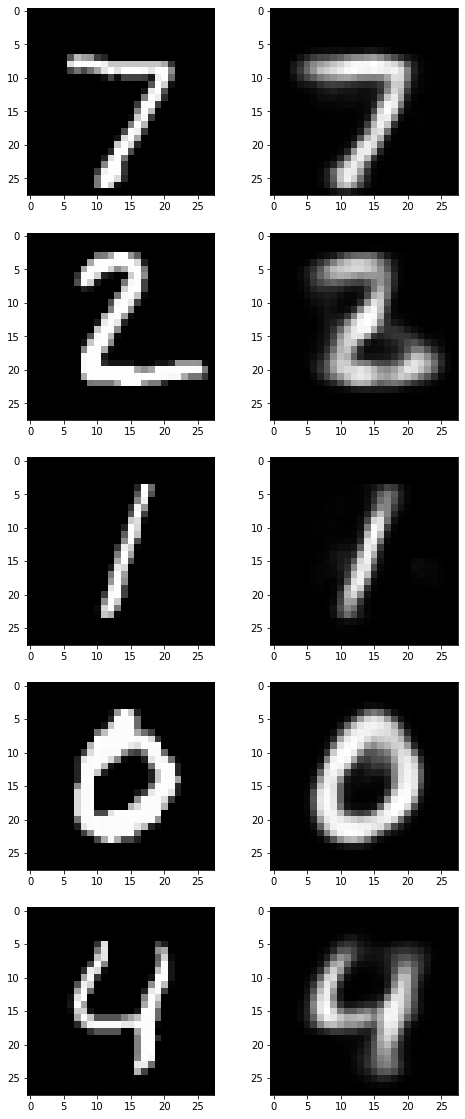

In [ ]:
# Examine the work of VAE on the MNIST dataset

model.eval()

with torch.no_grad():
    for batch in val_loader:
        ground_truth = batch[0].numpy()
        reconstructions, _, _ = model(batch[0].to(device))
        reconstructions = reconstructions.cpu().detach().numpy()
        break


plt.figure(figsize=(8, 20))

for i, (gt, res) in enumerate(zip(ground_truth[:5], reconstructions[:5])):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(np.squeeze(gt), cmap="gray")
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(np.squeeze(res.reshape(28, 28)), cmap="gray")

plt.show()

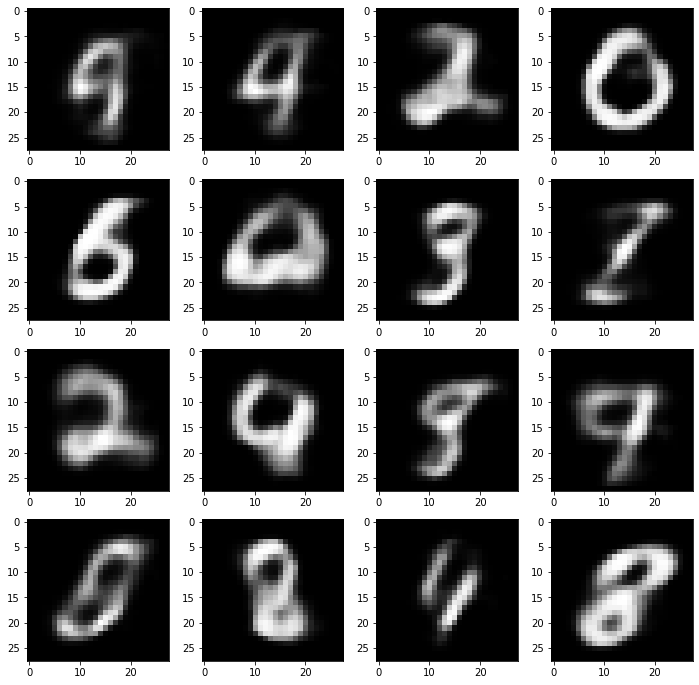

In [ ]:
z = np.array([np.random.normal(0, 1, 8) for i in range(16)])

plt.figure(figsize=(12, 12))

model.eval()
with torch.no_grad():
    for i in range(16):
        reconstruction = model.decoder(torch.from_numpy(z[i]).float().to(device)).cpu().detach().numpy()
        plt.subplot(4, 4, i + 1)
        plt.imshow(reconstruction.reshape(28, 28), cmap="gray")

plt.show()

In [ ]:
inference_loader = data_utils.DataLoader(data_test, batch_size=1)

test_targets = np.array([batch[1].cpu().detach().numpy() for batch in inference_loader]).flatten()

10000


In [ ]:
def crop_after_nth_true(bool_mask: np.array, n: int):

    if(bool_mask.sum() < n):
        raise RuntimeError("There are no as much target objects in the dataset")

    while bool_mask.sum() > n:
        bool_mask = bool_mask[: bool_mask.size - 1]

    return bool_mask


def get_2d_embeddings(latents: np.array): pass

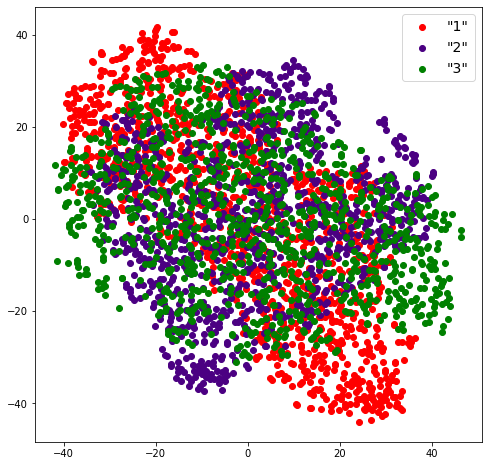

In [ ]:
from sklearn.manifold import TSNE


mask = (test_targets == 1) + (test_targets == 2) + (test_targets == 3)
idx = np.arange(len(mask))[mask]

data_test_small = data_utils.Subset(data_test, idx)
loader = data_utils.DataLoader(data_test_small, batch_size=10)

latents = list()
targets = list()


model.eval()
with torch.no_grad():
    for batch in loader:
        targets.extend(batch[1].numpy())
        batch = batch[0].to(device).float()
        latents.extend(model.get_latent_vector(batch).cpu().detach().numpy())

latents = np.array(latents)
targets = np.array(targets)

latents_embedded_1 = TSNE(n_components=2, perplexity=30).fit_transform(latents[targets == 1])      # with default perplexity
latents_embedded_2 = TSNE(n_components=2, perplexity=30).fit_transform(latents[targets == 2])      # with default perplexity
latents_embedded_3 = TSNE(n_components=2, perplexity=30).fit_transform(latents[targets == 3])      # with default perplexity

plt.figure(figsize=(8, 8))

plt.scatter(latents_embedded_1[:, 0], latents_embedded_1[:, 1], color="red", label="\"1\"")
plt.scatter(latents_embedded_2[:, 0], latents_embedded_2[:, 1], color="indigo", label="\"2\"")
plt.scatter(latents_embedded_3[:, 0], latents_embedded_3[:, 1], color="green", label="\"3\"")
plt.legend(prop={'size': 14})
plt.show()        

###**2) Conditional Variational Autoencoder (CVAE)**

In [ ]:
# Conditional VAE for working with MNIST


latent_dim = 8


class CVAE_MNIST(nn.Module):

    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28 + 10, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=latent_dim*2)                                                       
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim + 10, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=28*28),
            nn.Sigmoid()
        )

    def encode(self, x, labels):
        x = x.view(-1, 28*28)
        
        return self.encoder(torch.cat((x, labels), dim=1))   # dim=0 by default

    def sample(self, d_mean, d_log_var):
        if self.training:
            std = torch.exp(0.5 * d_log_var)  
            eps = torch.randn_like(std)        # random piece
            sample = d_mean + (eps * std) 
        else:
            sample = d_mean

        return sample
    

    def decode(self, z, labels):

        return self.decoder(torch.cat((z, labels), dim=1))
    
    def forward(self, x, labels):
        x = self.encode(x.to(device).float(), labels.float()).view(-1, 2, latent_dim)
        d_mean = x[:, 0, :]
        d_log_var = x[:, 1, :]

        z = self.sample(d_mean, d_log_var)

        reconstruction = self.decode(z, labels)

        return reconstruction, d_mean, d_log_var
    
    @staticmethod
    def one_hot_encoder(labels: torch.Tensor, num_classes: int):
        res = torch.zeros(labels.size(0), num_classes)

        for i, label in enumerate(labels):
            res[i, label] = 1
        
        return res.to(device)

In [ ]:
# Training preparation

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
criterion = VAE_loss
model = CVAE_MNIST().to(device)                                    # maybe FCAE(16): make dimension as an __init__() parameter
optimizer = optim.Adam(model.parameters(), lr=3e-4)                # Karpathy constant

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 train loss: 1795.7507576497396
Epoch 2 train loss: 1239.9164212239584
Epoch 3 train loss: 1138.4183063151042
Epoch 4 train loss: 1083.4360587890626
Epoch 5 train loss: 1054.2819764973958
Epoch 6 train loss: 1032.9627321614582
Epoch 7 train loss: 1015.9108431315104
Epoch 8 train loss: 1001.4323407552083
Epoch 9 train loss: 990.56081171875
Epoch 10 train loss: 981.0747785807291
Epoch 11 train loss: 972.70555234375
Epoch 12 train loss: 965.8116454427084
Epoch 13 train loss: 960.020468782552
Epoch 14 train loss: 954.6306510416666
Epoch 15 train loss: 950.197509765625
Epoch 16 train loss: 945.8493189778645
Epoch 17 train loss: 942.2546298177083
Epoch 18 train loss: 938.8541180664063
Epoch 19 train loss: 936.3383125325521
Epoch 20 train loss: 932.9342004231771


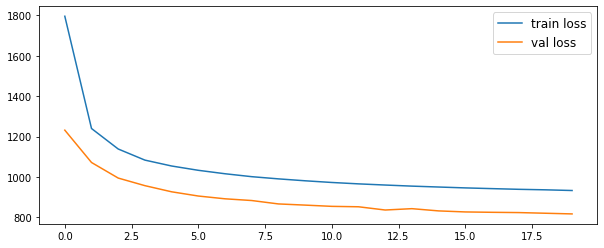

In [ ]:
n_epochs = 20
train_losses = list()
val_losses = list()

plt.figure(figsize=(10, 4))


for epoch in tqdm(range(n_epochs)):             # trange will add a progress bar

    train_losses_in_epoch = list()
    model.train()
    for i_b, batch in enumerate(train_loader):
        labels = batch[1]
        labels = CVAE_MNIST.one_hot_encoder(labels, 10)
        images = batch[0].to(device)

        # "Отче наш" / "Our Lord"
        optimizer.zero_grad()
        reconstruction, p_mean, p_log_var = model(images, labels)
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(images.float(), reconstruction, p_mean, p_log_var)
        loss.backward()
        optimizer.step()

        train_losses_in_epoch.append(loss.item())
    
    print(f"Epoch {epoch + 1} train loss: {np.mean(train_losses_in_epoch)}")
    train_losses.append(np.mean(train_losses_in_epoch))

    val_losses_in_epoch = list()
    model.eval()
    for i_b, batch in enumerate(val_loader):
        labels = batch[1].to(device)
        labels = CVAE_MNIST.one_hot_encoder(labels, 10)
        images = batch[0].to(device)
        
        reconstruction, p_mean, p_log_var = model(images, labels)
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(images.float(), reconstruction, p_mean, p_log_var)
        val_losses_in_epoch.append(loss.item())
    
    val_losses.append(np.mean(val_losses_in_epoch))

plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend(prop={'size': 12})
plt.show()

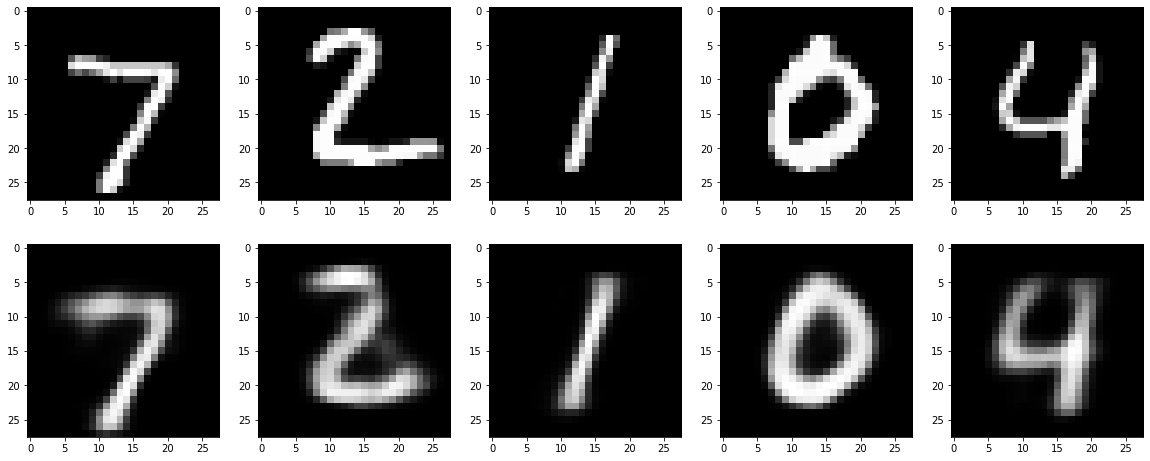

In [ ]:
# Examine the work of СVAE on the MNIST dataset

model.eval()

with torch.no_grad():
    for (images, labels) in val_loader:
        ground_truth = images.numpy()
        labels = CVAE_MNIST.one_hot_encoder(labels, 10)
        reconstructions, _, _ = model(images.to(device), labels)
        reconstructions = reconstructions.cpu().detach().numpy()
        break


plt.figure(figsize=(20, 8))

for i, (gt, res) in enumerate(zip(ground_truth[:5], reconstructions[:5])):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.squeeze(gt), cmap="gray")
    plt.subplot(2, 5, i+6)
    plt.imshow(np.squeeze(res.reshape(28, 28)), cmap="gray")

plt.show()

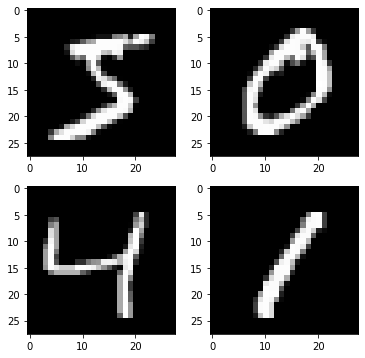

In [ ]:
# Посмотрим на первые 4 изображения тренировочного датасета, и заметим, что вторым идет ноль.
# Его будет интересно подекодить как шестёрку / восьмерку / девятку

plt.figure(figsize=(6, 6))

for i, (image, label) in enumerate(data_utils.Subset(data_train, torch.from_numpy(np.arange(4)))):
    plt.subplot(2, 2, i+1)
    plt.imshow(image.squeeze(), cmap="gray")

plt.show()

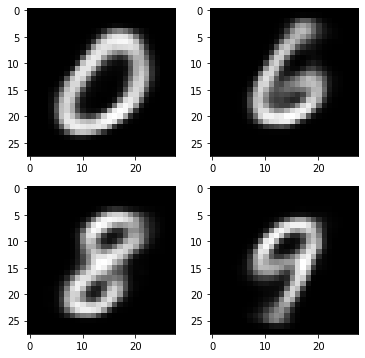

In [ ]:
zero_image = data_train[1][0].to(device)  # переложение на GPU есть в forward()
zero_encoded_label = CVAE_MNIST.one_hot_encoder(torch.tensor((data_train[1][1],)), 10) # -> tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

encoded_label_6 = torch.tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]]).to(device)
encoded_label_8 = torch.tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]]).to(device)
encoded_label_9 = torch.tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]).to(device)

model.eval()
with torch.no_grad():
    latent_zero_mean = model.encode(zero_image, zero_encoded_label).view(-1, 2, latent_dim)[:, 0, :]
    latent_zero_sample = model.sample(latent_zero_mean, 0)

    decoded_0 = model.decode(latent_zero_sample, zero_encoded_label)
    decoded_6 = model.decode(latent_zero_sample, encoded_label_6)
    decoded_8 = model.decode(latent_zero_sample, encoded_label_8)
    decoded_9 = model.decode(latent_zero_sample, encoded_label_9)

plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.imshow(decoded_0.squeeze().cpu().detach().numpy().reshape(28, 28), cmap="gray")
plt.subplot(2, 2, 2)
plt.imshow(decoded_6.squeeze().cpu().detach().numpy().reshape(28, 28), cmap="gray")
plt.subplot(2, 2, 3)
plt.imshow(decoded_8.squeeze().cpu().detach().numpy().reshape(28, 28), cmap="gray")
plt.subplot(2, 2, 4)
plt.imshow(decoded_9.squeeze().cpu().detach().numpy().reshape(28, 28), cmap="gray")

plt.show()

In [ ]:
inference_loader = data_utils.DataLoader(data_test, batch_size=1)

test_targets = np.array([batch[1].cpu().detach().numpy() for batch in inference_loader]).flatten()

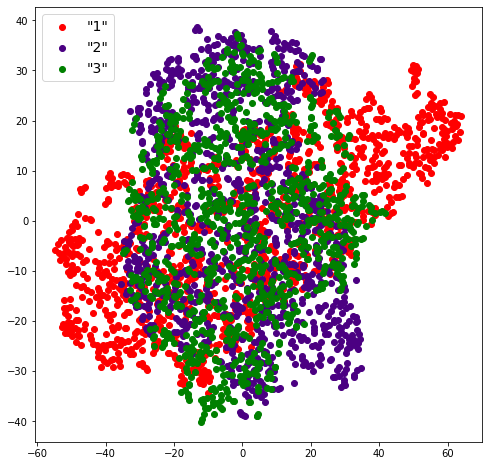

In [ ]:
from sklearn.manifold import TSNE


mask = (test_targets == 1) + (test_targets == 2) + (test_targets == 3)
idx = np.arange(len(mask))[mask]

data_test_small = data_utils.Subset(data_test, idx)
loader = data_utils.DataLoader(data_test_small, batch_size=10)

latents = list()
targets = list()


model.eval()
with torch.no_grad():
    for (images, labels) in loader:
        targets.extend(labels.numpy())
        images = images.to(device).float()
        labels = CVAE_MNIST.one_hot_encoder(labels, 10)
        encoded = model.encode(images, labels)
        latents.extend(torch.cat((model.sample(encoded, 0), labels), dim=1).cpu().detach().numpy())

latents = np.array(latents)
targets = np.array(targets)

latents_embedded_1 = TSNE(n_components=2, perplexity=30).fit_transform(latents[targets == 1])      # with default perplexity
latents_embedded_2 = TSNE(n_components=2, perplexity=30).fit_transform(latents[targets == 2])      # with default perplexity
latents_embedded_3 = TSNE(n_components=2, perplexity=30).fit_transform(latents[targets == 3])      # with default perplexity

plt.figure(figsize=(8, 8))

plt.scatter(latents_embedded_1[:, 0], latents_embedded_1[:, 1], color="red", label="\"1\"")
plt.scatter(latents_embedded_2[:, 0], latents_embedded_2[:, 1], color="indigo", label="\"2\"")
plt.scatter(latents_embedded_3[:, 0], latents_embedded_3[:, 1], color="green", label="\"3\"")
plt.legend(prop={'size': 14})
plt.show()

In [ ]:
# Странно, что распределения эмбеддингов никак особо не отличаются от случая с обыкновенным VAE
# Хотя я ожидал, что будут сдвинутые гауссовские (ну или что-то похожее на это)